In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold

from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import time

In [2]:
games = pd.read_csv('games.csv.zip')


games.drop(columns = 'GAME_STATUS_TEXT', inplace = True)
games.head(5)




,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,0.382,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,0.457,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,0.313,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,0.297,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,0.378,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [3]:
#Dataframe containing team info
teams = pd.read_csv('teams.csv')
display(teams.head(5))

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [4]:
#Data Preprocessing

team_id = list(teams['TEAM_ID'])
team_name = list(teams['ABBREVIATION'])

hometeamsdf = pd.DataFrame({'HOME_TEAM_ID':team_id, 'HOME_TEAM': team_name})
awayteamsdf = pd.DataFrame({'VISITOR_TEAM_ID':team_id, 'VISITOR_TEAM': team_name})
#Creating DataFrames for Team Name matched up with Team ID

games_merge = pd.merge(pd.merge(games, hometeamsdf, on = 'HOME_TEAM_ID'), awayteamsdf, on = 'VISITOR_TEAM_ID')
#Joining DataFrames to add Team Name Columns using team ID

games_merge = games_merge[games_merge['PTS_home'] > 0]
#Removing rows with 0 stat values

games_merge['home'] = 1
#Assigning home binary variable

games_merge.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID_home', 'TEAM_ID_away'], inplace = True)
games_merge.sort_values(by = 'GAME_DATE_EST', inplace = True)
games_merge.reset_index(inplace = True)
games_merge.drop(columns = 'index', inplace = True)
display(games_merge.head(5))



,GAME_DATE_EST,GAME_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_TEAM,VISITOR_TEAM,home
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,UTA,DAL,1
1,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,MEM,MIL,1
2,2003-10-07,10300004,2003,99.0,0.488,0.667,0.167,20.0,52.0,89.0,0.408,0.727,0.350,15.0,34.0,1,DAL,ORL,1
3,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,0.494,0.690,0.667,25.0,52.0,0,DET,CLE,1
4,2003-10-07,10300005,2003,104.0,0.527,0.657,0.429,22.0,33.0,80.0,0.470,0.667,0.333,10.0,37.0,1,POR,HOU,1


In [5]:
display(games_merge.drop(columns = ['GAME_ID', 'FG_PCT_home', 'FG_PCT_away','FT_PCT_home', 'FG3_PCT_home', 'FT_PCT_away', 'FG3_PCT_away','home']))



,GAME_DATE_EST,SEASON,PTS_home,AST_home,REB_home,PTS_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_TEAM,VISITOR_TEAM
0,2003-10-05,2003,90.0,23.0,41.0,85.0,20.0,38.0,1,UTA,DAL
1,2003-10-06,2003,105.0,25.0,48.0,94.0,20.0,43.0,1,MEM,MIL
2,2003-10-07,2003,99.0,20.0,52.0,89.0,15.0,34.0,1,DAL,ORL
3,2003-10-07,2003,96.0,19.0,37.0,100.0,25.0,52.0,0,DET,CLE
4,2003-10-07,2003,104.0,22.0,33.0,80.0,10.0,37.0,1,POR,HOU
...,...,...,...,...,...,...,...,...,...,...,...
26547,2022-12-21,2022,143.0,42.0,32.0,113.0,32.0,36.0,1,BKN,GSW
26548,2022-12-21,2022,114.0,22.0,37.0,106.0,20.0,46.0,1,CLE,MIL
26549,2022-12-21,2022,134.0,29.0,46.0,120.0,25.0,39.0,1,SAC,LAL
26550,2022-12-22,2022,120.0,16.0,40.0,112.0,20.0,37.0,1,UTA,WAS


In [6]:
#Duplicating each row but switching stats to create Team vs opp instead of home vs away
#Ex: Row 1 = UTA vs DAL
#Now: Row 2 = DAL vs UTA
# With same stats to capture stats for both teams for rolling averages

games = games_merge

games_append_away = games.copy()

games_append_away['home'] = 0
#Assigning value of 0 for 'home' column for away team dataframe

games_append_away.columns = ['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'PTS_away', 'FG_PCT_away',
                              'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
                              'FG3_PCT_home', 'AST_home', 'REB_home' , 'HOME_TEAM_WINS','VISITOR_TEAM', 'HOME_TEAM', 'home']
#Assigning columns to switch home stats with away stats

games_both = pd.concat([games, games_append_away])
#Concatenating away team data rows as main team

games_both.sort_values(by = ['GAME_DATE_EST', 'GAME_ID'], inplace = True)
games_both.reset_index(inplace = True, drop = True)

games_both.rename(columns = {'PTS_home': 'PTS', 'FG_PCT_home': 'FG_PCT', 'FT_PCT_home':'FT_PCT', 'FG3_PCT_home':'FG3_PCT', 'AST_home': 'AST', 'REB_home': 'REB', 'PTS_away': 'PTS_opp',
       'FG_PCT_away': 'FG_PCT_opp', 'FT_PCT_away': 'FT_PCT_opp', 'FG3_PCT_away': 'FG3_PCT_opp', 'AST_away': 'AST_opp', 'REB_away': 'REB_opp',
       'HOME_TEAM_WINS': 'WIN', 'HOME_TEAM': 'TEAM', 'VISITOR_TEAM': 'TEAM_opp'}, inplace = True)
#Renaming columns from Home vs Away to Team vs Opponent

games_both['WIN'] = (games_both['PTS'] > games_both['PTS_opp']).astype(int)
#Recreating logic for WIN column (Duplicated rows for away team still had same WIN value as home team df)

games_both['diff'] = (games_both['PTS'] - games_both['PTS_opp']).astype(int)
#Assigning column for point differential of each game (+ = win, - = loss)

display(games_both.head(5))

,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,FG_PCT_opp,FT_PCT_opp,FG3_PCT_opp,AST_opp,REB_opp,WIN,TEAM,TEAM_opp,home,diff
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,UTA,DAL,1,5
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,0.457,0.735,0.143,23.0,41.0,0,DAL,UTA,0,-5
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,MEM,MIL,1,11
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,0.494,0.618,0.267,25.0,48.0,0,MIL,MEM,0,-11
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,0.494,0.690,0.667,25.0,52.0,0,DET,CLE,1,-4


In [7]:
nuggets10 = games_both[games_both['TEAM'] == 'DEN']

display(nuggets10.drop(columns = ['GAME_ID', 'FG_PCT', 'FG_PCT_opp','FT_PCT_opp', 'FG3_PCT_opp', 'FT_PCT', 'FG3_PCT', 'TARGET_diff', 'diff', 'GAME_DATE_EST' ]).head(10))



KeyError: ignored

In [8]:

def add_target_win(team):
  team['TARGET_WIN'] = team['WIN'].shift(-1)
  return team
#This function displays Result of Next Game in current game row (Win = 1, Loss = 0)

def add_target_diff(team):
  team['TARGET_diff'] = team['diff'].shift(-1)
  return team
#This function displays Point Differential (diff) of Next Game in current game row (+ = Win, - = Loss)

games_both = games_both.groupby('TEAM', group_keys = False).apply(add_target_diff)

games_both = games_both.groupby('TEAM', group_keys = False).apply(add_target_win)
games_both['TARGET_WIN'][pd.isnull(games_both['TARGET_WIN'])] = 2

games_both

Lakers = games_both[(games_both['TEAM'] == 'LAL')]
display(Lakers.head(11))

<ipython-input-8-1c982cd61cde>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_both['TARGET_WIN'][pd.isnull(games_both['TARGET_WIN'])] = 2


,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,...,FG3_PCT_opp,AST_opp,REB_opp,WIN,TEAM,TEAM_opp,home,diff,TARGET_diff,TARGET_WIN
34,2003-10-28,20300003,2003,109.0,0.506,0.600,0.350,32.0,46.0,93.0,...,0.280,17.0,46.0,1,LAL,DAL,1,16,4.0,1.0
103,2003-11-01,20300037,2003,103.0,0.457,0.692,0.154,24.0,52.0,99.0,...,0.471,22.0,38.0,1,LAL,PHX,0,4,15.0,1.0
108,2003-11-02,20300040,2003,87.0,0.425,0.682,0.364,28.0,46.0,72.0,...,0.200,22.0,46.0,1,LAL,GSW,1,15,6.0,1.0
129,2003-11-04,20300050,2003,113.0,0.460,0.610,0.421,25.0,48.0,107.0,...,0.474,22.0,52.0,1,LAL,MIL,0,6,3.0,1.0
157,2003-11-06,20300064,2003,120.0,0.435,0.622,0.214,19.0,66.0,117.0,...,0.467,19.0,47.0,1,LAL,SAS,0,3,-19.0,0.0
169,2003-11-07,20300070,2003,95.0,0.461,0.731,0.300,29.0,32.0,114.0,...,0.522,31.0,36.0,0,LAL,NOP,0,-19,-10.0,0.0
211,2003-11-10,20300091,2003,95.0,0.440,0.667,0.412,20.0,43.0,105.0,...,0.375,26.0,42.0,0,LAL,MEM,0,-10,15.0,1.0
250,2003-11-12,20300111,2003,94.0,0.416,0.622,0.286,22.0,47.0,79.0,...,0.333,15.0,44.0,1,LAL,TOR,1,15,5.0,1.0
276,2003-11-14,20300124,2003,94.0,0.474,0.724,0.167,18.0,41.0,89.0,...,0.200,22.0,36.0,1,LAL,DET,1,5,22.0,1.0
304,2003-11-16,20300138,2003,99.0,0.446,0.717,0.000,22.0,43.0,77.0,...,0.000,10.0,45.0,1,LAL,MIA,1,22,-10.0,0.0


In [ ]:
display(Lakers.drop(columns = ['GAME_ID', 'FG_PCT', 'FG_PCT_opp','FT_PCT_opp', 'FG3_PCT_opp', 'FT_PCT', 'FG3_PCT','home', 'diff', 'TARGET_diff']).tail(4))


,GAME_DATE_EST,SEASON,PTS,AST,REB,PTS_opp,AST_opp,REB_opp,WIN,TEAM,TEAM_opp,TARGET_WIN
53020,2022-12-16,2022,126.0,29.0,45.0,108.0,25.0,39.0,1,LAL,DEN,1.0
53048,2022-12-18,2022,119.0,29.0,43.0,117.0,24.0,48.0,1,LAL,WAS,0.0
53065,2022-12-19,2022,104.0,13.0,38.0,130.0,21.0,51.0,0,LAL,PHX,0.0
53097,2022-12-21,2022,120.0,25.0,39.0,134.0,29.0,46.0,0,LAL,SAC,2.0


In [9]:
games_both['TARGET_WIN'].value_counts()

0.0    26539
1.0    26535
2.0       30
Name: TARGET_WIN, dtype: int64

In [10]:
#Creating rolling averages for last 10 games stats

def find_team_averages(team):
    rolling = team.rolling(10).mean()
    return rolling

# games_both.groupby(['TEAM', 'SEASON'], group_keys = False, as_index = False).rolling(10).mean()

df_rolling_avg = games_both.groupby(['TEAM', 'SEASON'], group_keys = False).apply(find_team_averages)
display(df_rolling_avg)

df_rolling_avg.columns

<ipython-input-10-f599234242e7>:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['GAME_DATE_EST', 'TEAM', 'TEAM_opp'], dtype='object')
  rolling = team.rolling(10).mean()


,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,FG_PCT_opp,FT_PCT_opp,FG3_PCT_opp,AST_opp,REB_opp,WIN,home,diff,TARGET_diff,TARGET_WIN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,22200405.9,2022.0,112.9,0.4409,0.7595,0.3187,23.0,46.2,122.8,0.5019,0.7568,0.4175,27.8,46.0,0.1,0.5,-9.9,NaN,0.3
53100,22200404.3,2022.0,118.7,0.4857,0.7964,0.3418,26.4,44.4,116.0,0.4687,0.7500,0.3453,25.8,43.9,0.6,0.6,2.7,NaN,0.7
53101,22200395.6,2022.0,110.4,0.4762,0.7502,0.3343,25.1,43.1,117.0,0.4913,0.7790,0.3484,24.9,43.5,0.4,0.6,-6.6,NaN,0.6
53102,22200416.4,2022.0,114.8,0.4645,0.7415,0.3679,22.9,41.6,116.9,0.5107,0.7736,0.3733,24.8,44.5,0.5,0.6,-2.1,NaN,0.7


Index(['GAME_ID', 'SEASON', 'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB',
       'PTS_opp', 'FG_PCT_opp', 'FT_PCT_opp', 'FG3_PCT_opp', 'AST_opp',
       'REB_opp', 'WIN', 'home', 'diff', 'TARGET_diff', 'TARGET_WIN'],
      dtype='object')

In [11]:
rolling_columns = [f"{column}_10" for column in df_rolling_avg.columns]
#Creates list of column names with "_10" added to end (Signifying last 10 game avg)

df_rolling_avg.columns = rolling_columns


df = pd.concat([games_both, df_rolling_avg], axis = 1)
# df = df.drop(columns = ['home_10', 'TARGET_10'], axis = 1)

df

,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,...,FG_PCT_opp_10,FT_PCT_opp_10,FG3_PCT_opp_10,AST_opp_10,REB_opp_10,WIN_10,home_10,diff_10,TARGET_diff_10,TARGET_WIN_10
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,2022-12-21,22200476,2022,105.0,0.402,0.759,0.290,25.0,40.0,126.0,...,0.5019,0.7568,0.4175,27.8,46.0,0.1,0.5,-9.9,NaN,0.3
53100,2022-12-22,22200477,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,...,0.4687,0.7500,0.3453,25.8,43.9,0.6,0.6,2.7,NaN,0.7
53101,2022-12-22,22200477,2022,117.0,0.478,0.815,0.321,23.0,44.0,126.0,...,0.4913,0.7790,0.3484,24.9,43.5,0.4,0.6,-6.6,NaN,0.6
53102,2022-12-22,22200478,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,...,0.5107,0.7736,0.3733,24.8,44.5,0.5,0.6,-2.1,NaN,0.7


In [12]:
df = df.dropna()
df.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'PTS', 'FG_PCT', 'FT_PCT',
       'FG3_PCT', 'AST', 'REB', 'PTS_opp', 'FG_PCT_opp', 'FT_PCT_opp',
       'FG3_PCT_opp', 'AST_opp', 'REB_opp', 'WIN', 'TEAM', 'TEAM_opp', 'home',
       'diff', 'TARGET_diff', 'TARGET_WIN', 'GAME_ID_10', 'SEASON_10',
       'PTS_10', 'FG_PCT_10', 'FT_PCT_10', 'FG3_PCT_10', 'AST_10', 'REB_10',
       'PTS_opp_10', 'FG_PCT_opp_10', 'FT_PCT_opp_10', 'FG3_PCT_opp_10',
       'AST_opp_10', 'REB_opp_10', 'WIN_10', 'home_10', 'diff_10',
       'TARGET_diff_10', 'TARGET_WIN_10'],
      dtype='object')

In [91]:
nuggets = df[df['TEAM'] == 'DEN']

nuggets.loc[:,['SEASON',	'PTS_10',	'AST_10',	'REB_10',	'PTS_opp_10',	'AST_opp_10',	'REB_opp_10',	'TEAM',	'TEAM_opp',	'home',	'TARGET_WIN']].head(10)


,SEASON,PTS_10,AST_10,REB_10,PTS_opp_10,AST_opp_10,REB_opp_10,TEAM,TEAM_opp,home,TARGET_WIN
325,2003,89.2,17.4,47.3,90.2,22.4,47.7,DEN,MIN,0,1.0
346,2003,90.6,18.4,45.7,91.6,23.9,45.8,DEN,MIL,1,1.0
366,2003,92.9,21.2,46.8,90.1,23.5,45.8,DEN,WAS,1,0.0
389,2003,92.1,20.1,47.1,92.8,23.7,46.0,DEN,DAL,0,1.0
420,2003,97.1,21.6,47.2,93.7,23.8,45.3,DEN,PHX,1,1.0
462,2003,99.1,22.5,47.7,95.1,23.9,43.5,DEN,DAL,1,1.0
491,2003,98.7,22.5,47.2,93.3,22.9,42.4,DEN,LAC,0,1.0
518,2003,102.6,24.1,47.0,94.7,22.8,43.4,DEN,CLE,1,1.0
541,2003,103.8,24.2,45.3,95.9,22.1,43.2,DEN,GSW,0,1.0
560,2003,103.0,24.9,44.6,94.9,22.5,43.1,DEN,GSW,1,0.0


In [74]:
df.drop(columns = ['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'PTS', 'FG_PCT', 'FT_PCT',
       'FG3_PCT', 'AST', 'REB', 'PTS_opp', 'FG_PCT_opp', 'FT_PCT_opp',
       'FG3_PCT_opp', 'AST_opp', 'REB_opp', 'WIN', 'TEAM', 'TEAM_opp', 'home',
       'diff', 'TARGET_diff', 'TARGET_WIN', 'GAME_ID_10', 'SEASON_10',
       'PTS_10', 'FG_PCT_10', 'FT_PCT_10', 'FG3_PCT_10', 'AST_10', 'REB_10',
       'PTS_opp_10', 'FG_PCT_opp_10', 'FT_PCT_opp_10', 'FG3_PCT_opp_10',
       'AST_opp_10', 'REB_opp_10', 'WIN_10', 'home_10', 'diff_10',
       'TARGET_diff_10', 'TARGET_WIN_10'])

,home_next,team_opp_next,game_date_next
224,1.0,HOU,2003-11-13
235,1.0,MIN,2003-11-13
238,0.0,DEN,2003-11-14
241,0.0,BOS,2003-11-14
242,1.0,POR,2003-11-15
...,...,...,...
53069,NaN,None,None
53071,NaN,None,None
53072,NaN,None,None
53073,NaN,None,None


In [13]:
def next_game_info(team, column_name):
    next_column = team[column_name].shift(-1)
    return next_column


def add_next_game_info(df, column_name):
    return df.groupby('TEAM', group_keys = False).apply(lambda x: next_game_info(x, column_name))

#Functions to display next opponent in current row

df['home_next'] = add_next_game_info(df, 'home')
df['team_opp_next'] = add_next_game_info(df, 'TEAM_opp')
df['game_date_next'] = add_next_game_info(df, 'GAME_DATE_EST')

<ipython-input-13-d1b8ac774c4a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['home_next'] = add_next_game_info(df, 'home')
<ipython-input-13-d1b8ac774c4a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['team_opp_next'] = add_next_game_info(df, 'TEAM_opp')
<ipython-input-13-d1b8ac774c4a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [14]:
df.head(5)

# df[['TEAM', 'TEAM_opp']].head()

,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,...,AST_opp_10,REB_opp_10,WIN_10,home_10,diff_10,TARGET_diff_10,TARGET_WIN_10,home_next,team_opp_next,game_date_next
224,2003-11-11,20300098,2003,125.0,0.581,0.800,0.474,40.0,45.0,97.0,...,21.8,42.4,0.6,0.4,4.7,6.3,0.7,1.0,HOU,2003-11-13
235,2003-11-12,20300103,2003,89.0,0.431,0.686,0.500,14.0,47.0,82.0,...,22.4,42.7,0.4,0.5,-9.8,-9.7,0.4,1.0,MIN,2003-11-13
238,2003-11-12,20300105,2003,97.0,0.452,0.667,0.250,20.0,47.0,107.0,...,20.9,45.2,0.1,0.6,-9.0,-8.5,0.1,0.0,DEN,2003-11-14
241,2003-11-12,20300106,2003,83.0,0.451,0.567,0.250,21.0,42.0,88.0,...,21.1,39.9,0.4,0.3,-1.8,-3.1,0.3,0.0,BOS,2003-11-14
242,2003-11-12,20300107,2003,96.0,0.463,0.786,0.500,24.0,30.0,89.0,...,23.8,40.9,0.7,0.6,1.3,2.8,0.7,1.0,POR,2003-11-15


In [15]:
#Merging Data of Opponent last 10 games

final = df.merge(df[rolling_columns + ['team_opp_next', 'TEAM', 'game_date_next']], left_on = ['TEAM', 'game_date_next'], right_on = ['team_opp_next', 'game_date_next'])
#Merging team stats with team opponent stats using next game date

final.columns
#Columns with x are "TEAM"
# Columns with y are Opponent
final[['TEAM_x', 'TEAM_y', 'home_next']]

,TEAM_x,TEAM_y,home_next
0,ATL,BKN,1.0
1,BOS,NYK,0.0
2,CLE,PHI,1.0
3,BKN,ATL,0.0
4,WAS,SAS,1.0
...,...,...,...
47371,GSW,NYK,0.0
47372,MIN,DAL,1.0
47373,CHA,SAC,0.0
47374,LAL,PHX,0.0


In [16]:
predictors = ['PTS_10_x', 'FG_PCT_10_x', 'FT_PCT_10_x', 'FG3_PCT_10_x',
       'AST_10_x', 'REB_10_x', 'PTS_opp_10_x', 'FG_PCT_opp_10_x',
       'FT_PCT_opp_10_x', 'FG3_PCT_opp_10_x', 'AST_opp_10_x', 'REB_opp_10_x',
       'WIN_10_x', 'home_10_x', 'diff_10_x', 'home_next','PTS_10_y', 'FG_PCT_10_y', 'FT_PCT_10_y',
       'FG3_PCT_10_y', 'AST_10_y', 'REB_10_y', 'PTS_opp_10_y',
       'FG_PCT_opp_10_y', 'FT_PCT_opp_10_y', 'FG3_PCT_opp_10_y',
       'AST_opp_10_y', 'REB_opp_10_y', 'WIN_10_y', 'home_10_y', 'diff_10_y']

train_x = final[final['SEASON'] < 2018][predictors]
test_x = final[final['SEASON'] >= 2018][predictors]

train_y = final[final['SEASON'] < 2018]['TARGET_WIN']
test_y = final[final['SEASON'] >= 2018]['TARGET_WIN']


In [ ]:
# hyper_params = [{'n_features_to_select': list(range(1, 15))}]

# folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# classifier = DecisionTreeClassifier()
# rfe = RFE(classifier)

# model_cv = GridSearchCV(estimator = rfe,
#                         param_grid = hyper_params,
#                         scoring= 'f1_weighted',
#                         cv = folds,
#                         return_train_score = True,
#                         n_jobs = -1)

In [ ]:

# start = time.time()
# model_cv.fit(train_x, train_y)
# stop = time.time()
# print(f"Training time: {stop - start}s")

Training time: 1222.917309999466s


In [ ]:
# # Return set of parameters with the best performance
# print(model_cv.best_params_)
# # Return the performance metric score
# print(model_cv.best_score_)


{'n_features_to_select': 6}
0.5439854245471831


In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,37.346264,1.370066,0.019741,0.007979,1,{'n_features_to_select': 1},0.505937,0.495387,0.493200,0.496959,...,0.500299,0.006508,14,0.599225,0.589227,0.588642,0.601417,0.59647,0.594996,0.005195
1,37.125633,1.076433,0.016878,0.003461,2,{'n_features_to_select': 2},0.496576,0.504766,0.498837,0.504234,...,0.501635,0.003302,13,0.995871,0.996374,0.994763,0.994931,0.99577,0.995542,0.000606
2,36.788893,0.892854,0.015014,0.000783,3,{'n_features_to_select': 3},0.508527,0.503559,0.509865,0.507187,...,0.509344,0.004623,12,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
3,35.323704,0.291410,0.014800,0.000413,4,{'n_features_to_select': 4},0.509728,0.518497,0.531870,0.513766,...,0.519437,0.007707,11,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
4,36.079797,0.671815,0.019158,0.009042,5,{'n_features_to_select': 5},0.534835,0.539547,0.535900,0.545706,...,0.539117,0.003808,9,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
5,34.762887,0.275906,0.014857,0.000799,6,{'n_features_to_select': 6},0.543554,0.549472,0.543706,0.544914,...,0.543985,0.003571,1,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
6,35.338391,0.904985,0.015464,0.002989,7,{'n_features_to_select': 7},0.531351,0.540874,0.543170,0.544896,...,0.540166,0.004685,6,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
7,33.932504,0.280963,0.016216,0.001930,8,{'n_features_to_select': 8},0.531354,0.544377,0.542489,0.538679,...,0.540023,0.004737,7,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
8,33.234073,0.142431,0.014837,0.000609,9,{'n_features_to_select': 9},0.526361,0.541427,0.550960,0.542347,...,0.538694,0.008524,10,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
9,32.667640,0.359165,0.021138,0.007667,10,{'n_features_to_select': 10},0.529205,0.539917,0.544501,0.549620,...,0.542587,0.007613,3,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000


In [ ]:
# # Finding 8 best features
# rfe = RFE(estimator = classifier, n_features_to_select = 6)

# rfe = rfe.fit(train_x, train_y)

In [ ]:
# rank = pd.DataFrame(list(zip(train_x.columns, rfe.support_, rfe.ranking_)),
#              columns = ['Feature','Whether selected', 'Rank'])

# display(rank)

# rank[rank['Whether selected'] == True]

,Feature,Whether selected,Rank
0,PTS_10_x,False,22
1,FG_PCT_10_x,True,1
2,FT_PCT_10_x,True,1
3,FG3_PCT_10_x,False,2
4,AST_10_x,False,10
5,REB_10_x,False,17
6,PTS_opp_10_x,False,16
7,FG_PCT_opp_10_x,False,4
8,FT_PCT_opp_10_x,True,1
9,FG3_PCT_opp_10_x,False,3


,Feature,Whether selected,Rank
1,FG_PCT_10_x,True,1
2,FT_PCT_10_x,True,1
8,FT_PCT_opp_10_x,True,1
14,diff_10_x,True,1
18,FT_PCT_10_y,True,1
30,diff_10_y,True,1


In [ ]:
# predictors_new = ['FT_PCT_opp_10_x',
#                   'diff_10_x', 'FT_PCT_10_y',
#                   'FG3_PCT_10_y', 'FG_PCT_opp_10_y',
#                   'diff_10_y']

# train_x = final[final['SEASON'] < 2018][predictors_new]
# test_x = final[final['SEASON'] >= 2018][predictors_new]

# train_y = final[final['SEASON'] < 2018]['TARGET_WIN']
# test_y = final[final['SEASON'] >= 2018]['TARGET_WIN']

In [ ]:
classifier.fit(train_x, train_y)

NameError: ignored

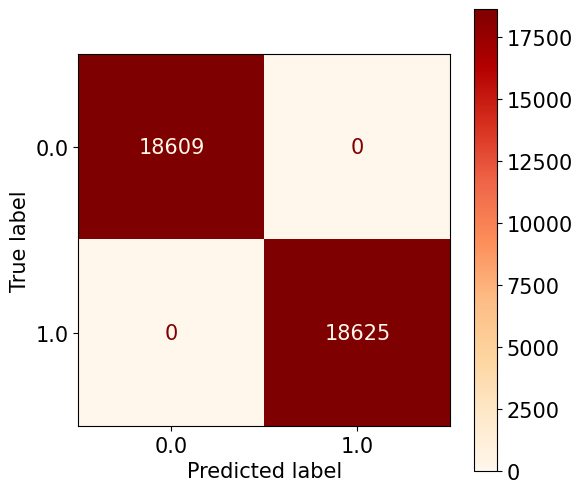

In [ ]:
from sklearn.metrics import accuracy_score

#Initial Decision Tree Classifier model

pred_y_train = classifier.predict(train_x)

# Now generate confusion matrix
cm = confusion_matrix(train_y, pred_y_train, labels = classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classifier.classes_)

# Specify figure size and font size
fig, ax = plt.subplots(figsize = (6, 6))
plt.rcParams.update({'font.size': 15})

# Display Confusion Matrix
disp.plot(cmap = 'OrRd', ax = ax);

Accuracy Score 0.5473


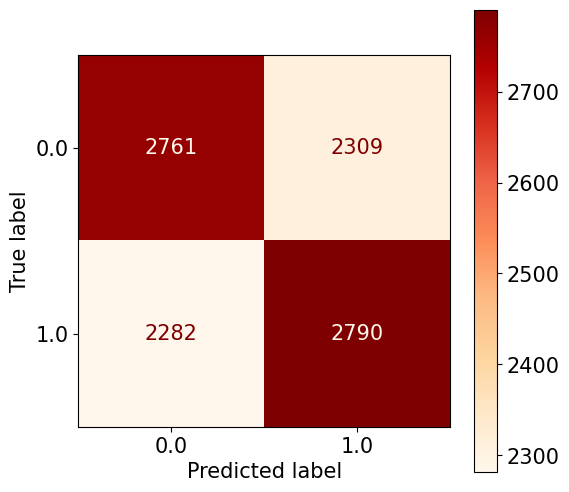

In [ ]:
#Test Data

pred_y = classifier.predict(test_x)
print('Accuracy Score', round(accuracy_score(pred_y, test_y),4))

cm = confusion_matrix(test_y, pred_y, labels = classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classifier.classes_)

# Specify figure size and font size
fig, ax = plt.subplots(figsize = (6, 6))
plt.rcParams.update({'font.size': 15})

# Display Confusion Matrix
disp.plot(cmap = 'OrRd', ax = ax);

In [43]:
#Decision Tree Hyperparameter Tuning

hyper_params = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [20, 40, 60],
    'min_samples_leaf': [10, 20, 30, 40, 100]
}

classifier = DecisionTreeClassifier()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = GridSearchCV(estimator = classifier,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training time: 187.409893989563s


In [ ]:
print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Initial score:  0.6288932805817925
Initial parameters:  {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 40}


In [ ]:
#2nd Run with adjusted hyperparameters
hyper_params = {
    'max_depth': [8, 10, 15],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [90, 100, 110]
}

model_cv = GridSearchCV(estimator = classifier,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:

start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training time: 67.63869404792786s


In [ ]:
print('2nd score: ', model_cv.best_score_)
print('2nd parameters: ', model_cv.best_params_)

2nd score:  0.6343014444791668
Initial parameters:  {'max_depth': 8, 'min_samples_leaf': 110, 'min_samples_split': 20}


In [ ]:
#3rd Run with adjusted hyperparameters
hyper_params = {
    'max_depth': [6, 7, 8, 9],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [106, 110, 114]
}

model_cv = GridSearchCV(estimator = classifier,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training time: 71.03839874267578s


In [ ]:
print('3rd score: ', model_cv.best_score_)
print('3rd parameters: ', model_cv.best_params_)

3rd score:  0.6421297589392692
Initial parameters:  {'max_depth': 6, 'min_samples_leaf': 114, 'min_samples_split': 5}


In [ ]:
#4th Run with adjusted hyperparameters
hyper_params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [114, 115, 116, 117]
}

model_cv = GridSearchCV(estimator = classifier,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Training time: 61.192036151885986s


In [ ]:
print('4th score: ', model_cv.best_score_)
print('4th parameters: ', model_cv.best_params_)

4th score:  0.6436077880120191
Initial parameters:  {'max_depth': 5, 'min_samples_leaf': 114, 'min_samples_split': 4}


In [44]:
#5th Run with adjusted hyperparameters
hyper_params = {
    'max_depth': [5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [112, 113, 114]
}

model_cv = GridSearchCV(estimator = classifier,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [45]:
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training time: 20.069324493408203s


In [46]:
print('5th score: ', model_cv.best_score_)
print('5th parameters: ', model_cv.best_params_)

5th score:  0.6436077880120191
5th parameters:  {'max_depth': 5, 'min_samples_leaf': 112, 'min_samples_split': 2}


In [50]:
importance = model_cv.best_estimator_.feature_importances_

feature_imp = pd.DataFrame(list(zip(train_x.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

display(feature_imp)

feature_imp_df = feature_imp[feature_imp['Importance'] > 0]
display(feature_imp_df)

,Feature,Importance
0,diff_10_x,0.342368
1,diff_10_y,0.338946
2,home_next,0.297694
3,WIN_10_y,0.009006
4,WIN_10_x,0.008802
5,FG3_PCT_opp_10_x,0.001715
6,FT_PCT_10_y,0.001469
7,FG3_PCT_10_x,0.000000
8,home_10_y,0.000000
9,REB_opp_10_y,0.000000


,Feature,Importance
0,diff_10_x,0.342368
1,diff_10_y,0.338946
2,home_next,0.297694
3,WIN_10_y,0.009006
4,WIN_10_x,0.008802
5,FG3_PCT_opp_10_x,0.001715
6,FT_PCT_10_y,0.001469


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'diff_10_x'),
  Text(0, 1, 'diff_10_y'),
  Text(0, 2, 'home_next'),
  Text(0, 3, 'WIN_10_y'),
  Text(0, 4, 'WIN_10_x'),
  Text(0, 5, 'FG3_PCT_opp_10_x'),
  Text(0, 6, 'FT_PCT_10_y')])

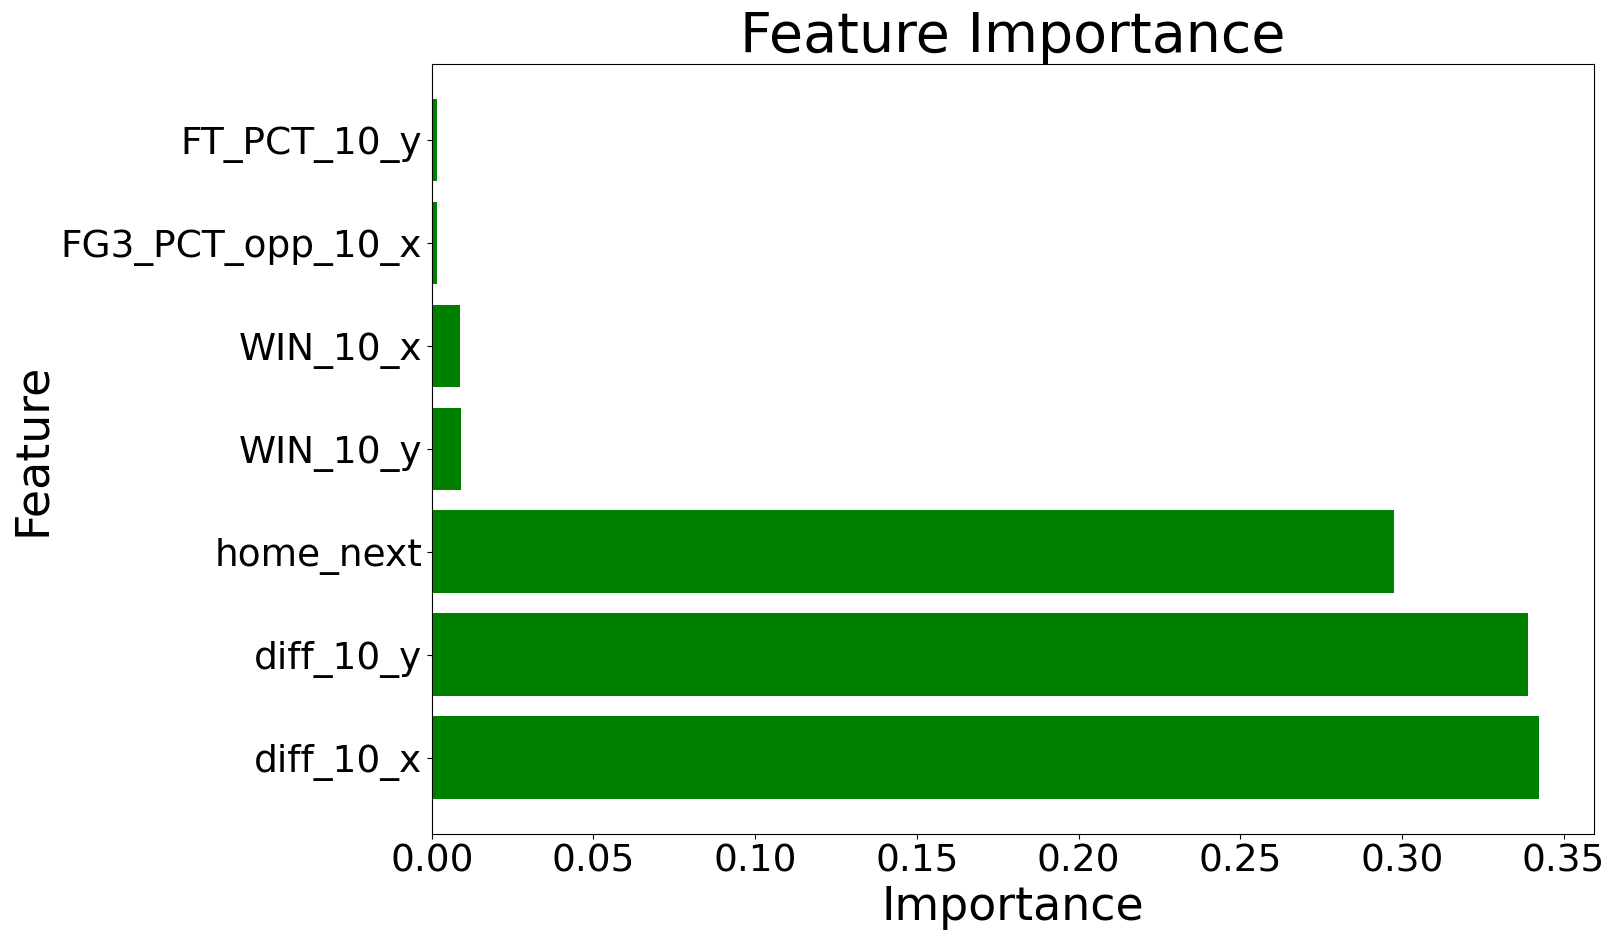

In [65]:
# Bar plot
plt.figure(figsize=(15, 10), dpi = 100)
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color ='green')

plt.xlabel("Importance", fontsize = 33)
plt.ylabel("Feature", fontsize = 33)
plt.title("Feature Importance", fontsize = 40);

plt.xticks(fontsize = 27)
plt.yticks(fontsize = 27)

In [15]:
# Optimal parameters:  {'max_depth': 6, 'min_samples_leaf': 107, 'min_samples_split': 2}

best_tree = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 112, min_samples_split = 2, random_state = 0)
best_tree.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=112, random_state=0)

F1 0.6048
Accuracy Score 0.6049


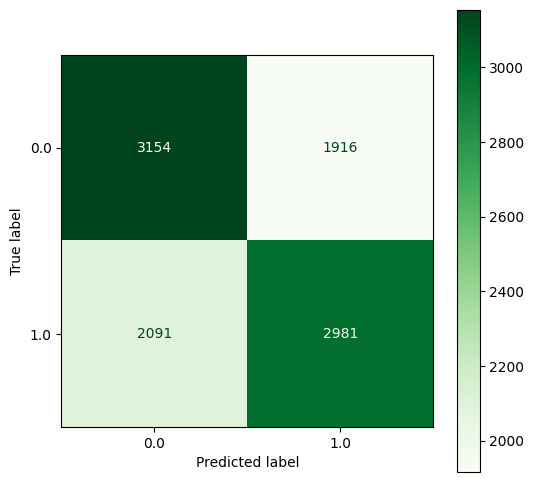

In [66]:
# Predictions on test set
y_pred = best_tree.predict(test_x)

# Now generate confusion matrix
cm = confusion_matrix(test_y, y_pred, labels = best_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_tree.classes_)

# Specify figure size
fig, ax = plt.subplots(figsize = (6, 6))

# Display Confusion Matrix
disp.plot(cmap = 'Greens', ax = ax);

print('F1', round(sklearn.metrics.f1_score(test_y, y_pred, average = 'macro'), 4))
print('Accuracy Score', round(accuracy_score(y_pred, test_y),4))

In [67]:
# Generating Classification Report
print("Classification Report - \n",
      classification_report(test_y, y_pred))

Classification Report - 
               precision    recall  f1-score   support

         0.0       0.60      0.62      0.61      5070
         1.0       0.61      0.59      0.60      5072

    accuracy                           0.60     10142
   macro avg       0.61      0.60      0.60     10142
weighted avg       0.61      0.60      0.60     10142



In [18]:
# Getting prediction probabilites
prob = best_tree.predict_proba(test_x)

# Printing prediction results
result = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})

# Creating columns for rejection and acceptance prob.
result[['Reject (0) Prob.','Accept (1) Prob.']] = pd.DataFrame(prob.tolist(), index = result.index)

display(result.head(10))

# Saving dataframe as a csv file
result.to_csv('Prediction Results.csv', index = False)

,Actual,Predicted,Reject (0) Prob.,Accept (1) Prob.
37234,1.0,1.0,0.279058,0.720942
37235,0.0,1.0,0.490887,0.509113
37236,1.0,1.0,0.177560,0.822440
37237,1.0,0.0,0.509113,0.490887
37238,0.0,1.0,0.366525,0.633475
37239,1.0,0.0,0.671459,0.328541
37240,1.0,1.0,0.328366,0.671634
37241,1.0,1.0,0.399614,0.600386
37242,0.0,0.0,0.550679,0.449321
37243,1.0,0.0,0.630910,0.369090


In [40]:
# result[result['Actual'] == result['Predicted'] & (result['Reject (0) Prob.'] >= 0.70 | result['Accept (1) Prob.'] >= 0.70)]
# Only considering instances where prob (0) or prob(1) > 70%.
# Calculating accuracy

(result[(result['Actual'] == result['Predicted']) & ((result['Reject (0) Prob.'] >= 0.70) | (result['Accept (1) Prob.'] >= 0.70))].size /
 (result[(result['Actual'] == result['Predicted']) & ((result['Reject (0) Prob.'] >= 0.70) | (result['Accept (1) Prob.'] >= 0.70))].size +
result[(result['Actual'] != result['Predicted']) & ((result['Reject (0) Prob.'] >= 0.70) | (result['Accept (1) Prob.'] >= 0.70))].size))


0.7330612244897959

In [17]:
# Models to use for hard voting
# Model 1
dt_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 112, min_samples_split = 2, random_state = 1)
# Model 2
rnd_clf = RandomForestClassifier(max_depth = 14, min_samples_leaf = 20, min_samples_split = 10, n_estimators = 350,random_state = 1)
# Model 3
ada_clf = AdaBoostClassifier(learning_rate = 0.25, n_estimators = 500, random_state = 1)

In [18]:
from sklearn.ensemble import VotingClassifier

# Implement hard voting classifier on train data
hard_voting_clf = VotingClassifier(estimators = [('dt', dt_clf), ('rf', rnd_clf), ('ada', ada_clf)],
                              voting = 'hard', n_jobs = -1)
hard_voting_clf.fit(train_x, train_y)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=6,
                                                     min_samples_leaf=112,
                                                     random_state=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=14,
                                                     min_samples_leaf=20,
                                                     min_samples_split=10,
                                                     n_estimators=350,
                                                     random_state=1)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.25,
                                                 n_estimators=500,
                                                 random_state=1))],
                 n_jobs=-1)

In [17]:
# Evaluate prediction performance on test data using F1 Score
for clf in (dt_clf, rnd_clf, ada_clf, hard_voting_clf):
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    print(clf.__class__.__name__, sklearn.metrics.f1_score(test_y, y_pred, average = 'macro'))

DecisionTreeClassifier 0.6097161553371477
RandomForestClassifier 0.6167399311404653
AdaBoostClassifier 0.6074691962358274
VotingClassifier 0.6198970089872508


In [19]:
# Implement soft voting classifier on train data
soft_voting_clf = VotingClassifier(estimators = [('dt', dt_clf), ('rf', rnd_clf), ('ada', ada_clf)],
                              voting = 'soft', n_jobs = -1)
soft_voting_clf.fit(train_x, train_y)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=6,
                                                     min_samples_leaf=112,
                                                     random_state=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=14,
                                                     min_samples_leaf=20,
                                                     min_samples_split=10,
                                                     n_estimators=350,
                                                     random_state=1)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.25,
                                                 n_estimators=500,
                                                 random_state=1))],
                 n_jobs=-1, voting='soft')

In [20]:
# Evaluate prediction performance on test data using F1 Score
for clf in (dt_clf, rnd_clf, ada_clf, soft_voting_clf):
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    print(clf.__class__.__name__, sklearn.metrics.f1_score(test_y, y_pred, average = 'macro'))

DecisionTreeClassifier 0.6097161553371477
RandomForestClassifier 0.6167399311404653
AdaBoostClassifier 0.6074691962358274
VotingClassifier 0.6136672596552764


In [21]:
rnd_clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=14, min_samples_leaf=20, min_samples_split=10,
                       n_estimators=350, random_state=1)

In [28]:
y_pred = rnd_clf.predict(test_x)

prob = rnd_clf.predict_proba(test_x)

# Printing prediction results
result = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})

# Creating columns for rejection and acceptance prob.
result[['Reject (0) Prob.','Accept (1) Prob.']] = pd.DataFrame(prob.tolist(), index = result.index)

display(result.head())
print('F1: ', sklearn.metrics.f1_score(y_pred, test_y))

,Actual,Predicted,Reject (0) Prob.,Accept (1) Prob.
37234,1.0,1.0,0.292767,0.707233
37235,0.0,0.0,0.610992,0.389008
37236,1.0,1.0,0.177936,0.822064
37237,1.0,1.0,0.371213,0.628787
37238,0.0,1.0,0.345912,0.654088


F1:  0.6176846660765221


0.6167422599092881

In [29]:
(result[(result['Actual'] == result['Predicted']) & ((result['Reject (0) Prob.'] >= 0.65) | (result['Accept (1) Prob.'] >= 0.65))].size /
 (result[(result['Actual'] == result['Predicted']) & ((result['Reject (0) Prob.'] >= 0.65) | (result['Accept (1) Prob.'] >= 0.65))].size +
result[(result['Actual'] != result['Predicted']) & ((result['Reject (0) Prob.'] >= 0.65) | (result['Accept (1) Prob.'] >= 0.65))].size))

0.6807984455043279

Alternate Improvement Techniques

In [ ]:
rnd_clf = RandomForestClassifier(max_depth = 14, min_samples_leaf = 20, min_samples_split = 10, n_estimators = 350,random_state = 1)

rnd_clf.fit(train_X, train_y)

In [ ]:
# Getting prediction probabilites

y_pred = rnd_clf.predict(test_X)
prob = rnd_clf.predict_proba(test_X)

# Printing prediction results
result = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})

# Creating columns for rejection and acceptance prob.
result[['Lose (0) Prob.','Win (1) Prob.']] = pd.DataFrame(prob.tolist(), index = result.index)

display(result.head(5))

# Saving dataframe as a csv file
result.to_csv('Prediction Results.csv', index = False)

print(sklearn.metrics.f1_score(y_pred, test_y))

In [ ]:
(result[(result['Actual'] == result['Predicted']) & ((result['Lose (0) Prob.'] >= 0.8) | (result['Win (1) Prob.'] >= 0.8))].size /
 (result[(result['Actual'] == result['Predicted']) & ((result['Lose (0) Prob.'] >= 0.8) | (result['Win (1) Prob.'] >= 0.8))].size +
result[(result['Actual'] != result['Predicted']) & ((result['Lose (0) Prob.'] >= 0.8) | (result['Win (1) Prob.'] >= 0.8))].size))

In [ ]:
alt_soln = pd.DataFrame({'Minimum Prediction Probability Required': [0.5, 0.6, 0.7], 'Accuracy': [0.65, 0.698, 0.766]})


In [ ]:
plt.plot(alt_soln['Minimum Prediction Probability Required'], alt_soln['Accuracy'])
plt.title('The Importance of Selective Betting', fontsize = 20)
plt.xlabel('Minimum Prediction Probability Required', fontsize = 13)
plt.ylabel('Classification Accuracy', fontsize = 13)

Predicting NBA games 12/2/23

In [ ]:
tester = pd.read_csv('nbatester.csv')

test_X = tester.drop(columns =['TARGET_WIN', 'TEAM', 'OPP'])

test_y = tester['TARGET_WIN']

y_pred = rnd_clf.predict(test_X)

In [ ]:
prob = rnd_clf.predict_proba(test_X)

# Printing prediction results
result = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})

# Creating columns for rejection and acceptance prob.
result[['Lose (0) Prob.','Win (1) Prob.']] = pd.DataFrame(prob.tolist(), index = result.index)

result['correct'] = result['Actual'] == result['Predicted']
display(result)

In [ ]:
(result[(result['Actual'] == result['Predicted']) & ((result['Lose (0) Prob.'] >= 0.6) | (result['Win (1) Prob.'] >= 0.6))].size /
 (result[(result['Actual'] == result['Predicted']) & ((result['Lose (0) Prob.'] >= 0.6) | (result['Win (1) Prob.'] >= 0.6))].size +
result[(result['Actual'] != result['Predicted']) & ((result['Lose (0) Prob.'] >= 0.6) | (result['Win (1) Prob.'] >= 0.6))].size))

Descriptive Data

In [ ]:
stats = pd.DataFrame(final.groupby(by = 'TEAM_x').agg('sum'))

stats_sort = stats.sort_values('WIN', ascending = False)
colors = ['g', 'g', 'g', 'g', 'g', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'r', 'r', 'r', 'r', 'r']

plt.bar(stats_sort.index, stats_sort['WIN'], color = colors)
plt.title("Number of Games Won Since 2003")
plt.xticks(rotation = 90)